In [80]:
# pipenv install pandas scipy plotly scikit-learn optuna shap ipykernel ipywidgets nbformat numpy

# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import plot_tree

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, f1_score, precision_score, recall_score

import optuna

import shap

### Carregar o dados

In [81]:
# Carregar o Dataset
df_employees = pd.read_csv('./datasets/employees_churn_dataset.csv', parse_dates=['data_contratacao', 'data_demissao', 'data_ultimo_feedback', 'data_ultimo_aumento', 'data_ultima_mudanca_cargo'], date_format='%Y-%m-%d')

In [82]:
# Visualizar estrutura do dataset
df_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

In [83]:
# Visualizar primeiras linhas
df_employees.head(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0
5,EMP1053,49,Outro,Casado(a),Technical Degree,Híbrido,2020-01-08,NaT,NaN,Junior Developer,6507,2022-06-01,2020-07-05,2021-09-02,7.9,True,8,4,7.1,0
6,EMP1152,29,M,Casado(a),PhD,Presencial,2020-01-10,2022-08-22,Involuntária,Product Manager,12575,2020-10-16,2020-08-11,2022-02-27,9.1,True,6,3,1.9,1
7,EMP1317,38,F,Viúvo(a),PhD,Remoto,2020-01-11,NaT,NaN,DevOps Engineer,16643,2023-03-28,2023-05-16,2022-03-28,8.9,False,6,4,8.3,0
8,EMP1398,33,M,Casado(a),Technical Degree,Remoto,2020-01-12,NaT,NaN,DevOps Engineer,16771,2024-01-03,2024-03-13,2024-06-15,7.6,False,8,1,1.2,0
9,EMP0167,23,M,Viúvo(a),PhD,Híbrido,2020-01-13,NaT,NaN,QA Engineer,13258,2022-01-02,2021-09-15,2024-04-04,8.1,True,3,6,7.0,0


In [84]:
# Visualizar primeiras linhas
df_employees.tail(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
1990,EMP0231,40,Outro,Viúvo(a),Master,Remoto,2024-07-19,NaT,NaN,Product Manager,15704,2024-09-29,2024-08-26,2024-07-29,7.0,False,1,4,3.7,0
1991,EMP1939,41,M,Divorciado(a),Bachelor,Presencial,2024-07-19,NaT,NaN,QA Engineer,6586,2024-10-21,2024-10-13,2024-09-08,8.8,False,6,6,7.9,0
1992,EMP1167,49,Outro,Viúvo(a),PhD,Híbrido,2024-07-20,NaT,NaN,Tech Lead,13820,2024-09-09,2024-07-22,2024-08-18,7.4,False,6,6,6.0,0
1993,EMP1926,40,F,Casado(a),Bachelor,Presencial,2024-07-20,NaT,NaN,Product Manager,7703,2024-09-15,2024-07-22,2024-07-24,8.6,True,4,5,5.6,0
1994,EMP1191,49,F,Solteiro(a),Technical Degree,Híbrido,2024-07-23,NaT,NaN,Product Manager,14965,2024-08-14,2024-07-28,2024-08-29,6.3,False,4,3,7.1,0
1995,EMP0353,50,Outro,Viúvo(a),Bachelor,Remoto,2024-07-23,NaT,NaN,QA Engineer,7378,2024-08-21,2024-09-03,2024-08-10,9.3,True,6,3,10.0,0
1996,EMP1808,26,F,Divorciado(a),PhD,Presencial,2024-07-24,2024-10-06,Voluntária,Senior Developer,8501,2024-09-17,2024-09-17,2024-10-04,9.9,False,4,6,4.7,1
1997,EMP0503,35,F,Viúvo(a),PhD,Presencial,2024-07-24,NaT,NaN,Senior Developer,22488,2024-10-14,2024-08-15,2024-10-19,8.0,False,6,1,6.8,0
1998,EMP1266,33,F,Viúvo(a),Technical Degree,Híbrido,2024-07-25,NaT,NaN,QA Engineer,13748,2024-09-20,2024-08-07,2024-10-11,8.7,False,8,1,2.6,0
1999,EMP1815,53,F,Solteiro(a),PhD,Presencial,2024-07-25,NaT,NaN,QA Engineer,16819,2024-10-09,2024-09-11,2024-09-04,7.9,False,9,2,2.3,0


In [85]:
# Visualizar últimos registros
df_employees.tail(20)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
1980,EMP1745,40,M,Casado(a),Technical Degree,Presencial,2024-07-08,NaT,NaN,UX Designer,6751,2024-09-27,2024-08-04,2024-07-09,6.5,False,5,4,1.3,0
1981,EMP0323,46,Outro,Divorciado(a),Technical Degree,Híbrido,2024-07-09,NaT,NaN,Tech Lead,7962,2024-08-15,2024-10-12,2024-08-21,8.4,True,9,1,3.2,0
1982,EMP0047,26,M,Solteiro(a),Master,Presencial,2024-07-10,NaT,NaN,Data Scientist,22749,2024-08-18,2024-08-09,2024-07-17,9.3,True,7,1,6.3,0
1983,EMP0063,24,Outro,Divorciado(a),Bachelor,Remoto,2024-07-11,NaT,NaN,Tech Lead,17891,2024-09-01,2024-08-04,2024-07-23,7.4,False,5,6,2.1,0
1984,EMP1864,46,M,Casado(a),Technical Degree,Presencial,2024-07-12,NaT,NaN,Senior Developer,10274,2024-08-03,2024-08-14,2024-10-20,6.1,True,6,1,7.6,0
1985,EMP1333,39,Outro,Divorciado(a),Bachelor,Remoto,2024-07-12,2024-09-20,Voluntária,Tech Lead,11728,2024-09-04,2024-08-02,2024-07-12,9.9,True,8,1,9.6,1
1986,EMP0071,24,Outro,Divorciado(a),Technical Degree,Híbrido,2024-07-12,2024-10-20,Voluntária,UX Designer,13659,2024-07-24,2024-07-18,2024-10-03,9.9,False,6,6,3.3,1
1987,EMP1740,39,M,Casado(a),Master,Híbrido,2024-07-12,NaT,NaN,Tech Lead,20329,2024-08-04,2024-09-28,2024-08-10,6.8,True,3,1,7.5,0
1988,EMP1858,44,M,Casado(a),Technical Degree,Híbrido,2024-07-14,NaT,NaN,Tech Lead,20987,2024-10-16,2024-10-01,2024-07-17,9.7,False,8,7,9.5,0
1989,EMP0688,26,F,Solteiro(a),PhD,Híbrido,2024-07-15,NaT,NaN,QA Engineer,9846,2024-10-07,2024-09-06,2024-10-01,8.5,True,3,7,2.1,0


### Engenharia de Features

In [86]:
# Criar features baseadas em datas (diferença em dias)

# Calcular tempo de empresa
df_employees['tempo_empresa'] = df_employees.apply(
    lambda x: 
        (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0
        else (x['data_demissao'] - x['data_contratacao']).days, axis=1
)

# Calcular tempo desde o último feedback
df_employees['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employees['data_ultimo_feedback']).dt.days

# Calcular tempo desde o último aumento
df_employees['dias_desde_ultimo_aumento'] = (pd.Timestamp.now() - df_employees['data_ultimo_aumento']).dt.days

# Calcular tempo desde o última mudança de cargo
df_employees['dias_desde_ultimo_mudanca_cargo'] = (pd.Timestamp.now() - df_employees['data_ultima_mudanca_cargo']).dt.days

In [87]:
# Remover Id
df_employees.drop(columns=['id'], axis=1, inplace=True)

### EDA

In [88]:
# Verificação de valores ausentes
print('Valores ausentes por coluna: ')
df_employees.isnull().sum()

Valores ausentes por coluna: 


idade                                 0
genero                                0
estado_civil                          0
educacao                              0
regime_trabalho                       0
data_contratacao                      0
data_demissao                      1714
tipo_demissao                      1714
cargo                                 0
salario_atual                         0
data_ultimo_feedback                  0
data_ultimo_aumento                   0
data_ultima_mudanca_cargo             0
nota_avaliacao                        0
acompanhamento_psicologo              0
qtde_projetos                         0
qtde_clientes                         0
nivel_satisfacao_gestor               0
churn                                 0
tempo_empresa                         0
dias_desde_ultimo_feedback            0
dias_desde_ultimo_aumento             0
dias_desde_ultimo_mudanca_cargo       0
dtype: int64

In [89]:
# Distribuição da varipavel target em percentual

fig = px.bar(
    df_employees['churn'].value_counts() / len(df_employees) * 100, 
    title='Fator de Churn',
    labels={'index': 'Churn', 'value': 'Percentual'},
    opacity=0.8
)

fig.update_layout(showlegend=False)
fig.show()

In [90]:
# Valores possíveis para variáveis categóricas
for col in df_employees.select_dtypes(include=['object']).columns:
    print(f'\nValores únicos em {col}: ')
    print(df_employees[col].unique())


Valores únicos em genero: 
['F' 'Outro' 'M']

Valores únicos em estado_civil: 
['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']

Valores únicos em educacao: 
['Master' 'Technical Degree' 'Bachelor' 'PhD']

Valores únicos em regime_trabalho: 
['Remoto' 'Híbrido' 'Presencial']

Valores únicos em tipo_demissao: 
[nan 'Involuntária' 'Voluntária']

Valores únicos em cargo: 
['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [91]:
# Estatísticas descritivas das variáveis numéricas
df_employees.select_dtypes(include=['int64', 'float64']).describe()

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultimo_mudanca_cargo
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,1000.810000,651.89900,665.005000,652.136500
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,508.547541,395.59628,397.623967,395.911115
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.000000,165.00000,166.000000,165.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,566.750000,321.75000,327.750000,325.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,999.500000,550.50000,565.000000,542.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1434.000000,891.25000,924.250000,885.000000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,1921.000000,1884.00000,1837.000000,1877.000000


In [92]:
# BoxPlots para variáveis numéricas com o Churn
for col in df_employees.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'churn':
        fig = px.box(df_employees, x='churn', y=col, title=f'BoxPlot de {col} vs Churn', color='churn')
        fig.show()

In [93]:
# Matriz de Correlação
colunas_numericas = df_employees.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_employees[colunas_numericas].corr()

fig = px.imshow(
    corr_matrix,
    title='Matriz de Correlação',
    color_continuous_scale='Viridis',
    zmin=-1,
    zmax=1
)

fig.update_traces(
    text=corr_matrix,
    texttemplate='%{text:.1%}',
    textfont={'size': 9}
)
fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)

fig.show()

In [94]:
# Matriz de dispersão
fig = px.scatter_matrix(
    df_employees,
    dimensions=colunas_numericas,
    color='churn',
    title='Matriz de Dispersão'
)

fig.update_layout(
    width=1200,
    height=1000,
    title_font=dict(size=14),
    font=dict(size=10)
)

fig.show()

In [95]:
# Teste de hipóteses para variáveis categóricas vs Churn
colunas_categoricas = df_employees.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    contingency_table = pd.crosstab(df_employees['churn'], df_employees[col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f'\nTeste Chi-Quadrado para {col} vs Churn')
    print(f'p-value: {p_value}')
    if p_value <= 0.05:
        print(f'As variáveis {col} e Churn não são independentes')
    else:
        print(f'As variáveis {col} e Churn são independentes')


Teste Chi-Quadrado para genero vs Churn
p-value: 0.6391382063144609
As variáveis genero e Churn são independentes

Teste Chi-Quadrado para estado_civil vs Churn
p-value: 0.8332629331272039
As variáveis estado_civil e Churn são independentes

Teste Chi-Quadrado para educacao vs Churn
p-value: 0.20475149121388256
As variáveis educacao e Churn são independentes

Teste Chi-Quadrado para regime_trabalho vs Churn
p-value: 0.9751275918764937
As variáveis regime_trabalho e Churn são independentes

Teste Chi-Quadrado para tipo_demissao vs Churn
p-value: 1.0
As variáveis tipo_demissao e Churn são independentes

Teste Chi-Quadrado para cargo vs Churn
p-value: 0.4586024122014406
As variáveis cargo e Churn são independentes


In [96]:
# Gráficos de barras para variáveis categóricas vs Chunr
for col in colunas_categoricas:
    fig = px.histogram(
        df_employees,
        x=col,
        color='churn', 
        barmode='group',
        title=f'Distribuição de {col} por Churn'
    )

    fig.show()

### Preparação dos dados

In [97]:
# Separar features e target

# Criar lista de colunas do tipo datetime
colunas_data = list(df_employees.select_dtypes(include=['datetime64']).columns)

# X e y
X = df_employees.drop(['churn', 'tipo_demissao'] + colunas_data, axis=1)
y = df_employees['churn']

In [98]:
# Criar preprocessador

# Lista de Colunas por Tipo
features_numericas = X.select_dtypes(include=['int64', 'float64']).columns
features_categoricas = X.select_dtypes(include=['object']).columns

# Preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ]
)

In [99]:
# Dividir os dados entre Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=51, shuffle=True)

# Aplicar o Column Transformer
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [100]:
# Mostrar os conjuntos
print(X_train.shape)
print(X_test.shape)

(1000, 32)
(1000, 32)


### Treinamento do Modelo - Baseline

In [101]:
# Criar o modelo de RandomForest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=51,
    max_features='sqrt',
    class_weight='balanced'
)

In [102]:
# Treinar o modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=51)

### Análise dos Resultados - Baseline

In [103]:
# Fazer predições (classificações - 0 ou 1)
y_pred = rf_model.predict(X_test)

# Mostrar y_pred
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [104]:
# Retornar as probabilidades das previsões
y_pred_proba = rf_model.predict_proba(X_test)

# Mostrar probabilidades
y_pred_proba

array([[0.97, 0.03],
       [0.99, 0.01],
       [0.94, 0.06],
       ...,
       [0.93, 0.07],
       [0.38, 0.62],
       [0.41, 0.59]])

In [105]:
# Avaliação do modelo
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       855
           1       1.00      0.43      0.60       145

    accuracy                           0.92      1000
   macro avg       0.96      0.71      0.78      1000
weighted avg       0.92      0.92      0.90      1000



In [106]:
# Retornar os valores da curva ROC - TPR vs FPR e Threshold (Pontos de Corte)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[: , 1])

In [107]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [108]:
# Plotar a Curva ROC com o valor do AUC
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0,
    x1=1,
    y0=0,
    y1=1
)

fig.update_yaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

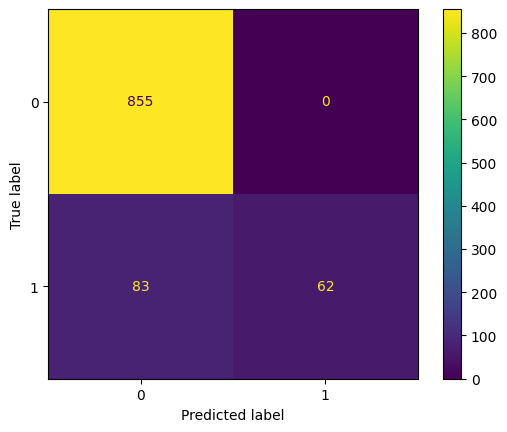

In [109]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

fig = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig.plot()

In [110]:
# Calcular log_loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.2134


### Treinar Modelo com Validação Cruzada e Tuning de Hiper parâmetros

In [111]:
# Criar um dicionário com os valores dos hiper parâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Configurar o GridSearchCV com 5 folds (com StratifiedKFold) e usando Recall como métrica
rf_model_cv = RandomForestClassifier(
    class_weight='balanced',
    random_state=51,
    max_features='sqrt'
)

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid, cv=kfolds, scoring='recall', verbose=2)



In [112]:
# Treinar o modelo usando cross-validation para buscar melhores hiper parâmetros
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_de

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=51, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=51),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=2)

###### Usando o conceito de Cross Validation, nós trabalhamos na verdade com conjunto de Treino + Val + Teste
###### X_train (50%) -> cross_validate -> 4 partições pra treino + 1 validação
###### Gera o melhor modelo e validamos com X_test (50%)

### Análise de Resultado - Grid SearchCV

In [113]:
# Retornar o melhor modelo
best_model = grid_search.best_estimator_

In [114]:
# Retornar melhores hiper parâmetros
best_params = grid_search.best_params_

In [115]:
# Retornar a melhor métrica
best_score = grid_search.best_score_

### Análise dos Resultados - Baseline

In [116]:
# Fazer predições (classificações - 0 ou 1)
y_pred = best_model.predict(X_test)

# Mostrar y_pred
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [117]:
# Retornar as probabilidades das previsões
y_pred_proba = best_model.predict_proba(X_test)

# Mostrar probabilidades
y_pred_proba

array([[0.9182854 , 0.0817146 ],
       [0.90157591, 0.09842409],
       [0.81257121, 0.18742879],
       ...,
       [0.84309778, 0.15690222],
       [0.25566951, 0.74433049],
       [0.32546451, 0.67453549]])

In [118]:
# Avaliação do modelo
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       855
           1       0.95      0.66      0.78       145

    accuracy                           0.95      1000
   macro avg       0.95      0.83      0.87      1000
weighted avg       0.95      0.95      0.94      1000



In [119]:
# Retornar os valores da curva ROC - TPR vs FPR e Threshold (Pontos de Corte)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[: , 1])

In [120]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [121]:
# Plotar a Curva ROC com o valor do AUC
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0,
    x1=1,
    y0=0,
    y1=1
)

fig.update_yaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

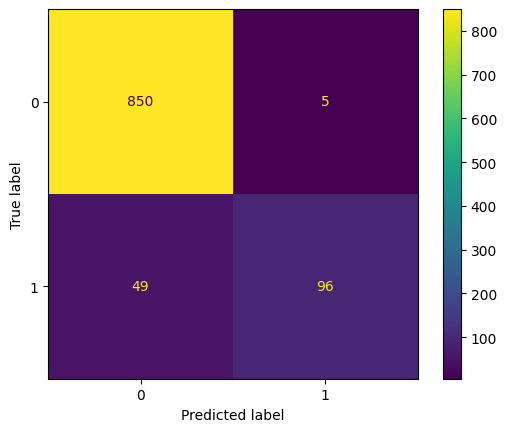

In [122]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

fig = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig.plot()

In [123]:
# Calcular log_loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.3067


### Ajustar Threshold

In [124]:
# Criar uma lista de thresholds para testar
threshoulds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Lista para armazenar métrica
recalls = []

# Calcular as métricas para cada threshold
for threshold in thresholds:
    # Fazer predições com o threshold
    y_pred_threshold = (y_pred_proba[: , 1] >= threshold).astype(int)

    # Calcular métrica
    recall = recall_score(y_test, y_pred_threshold)

    # Inserir métrica na lista
    recalls.append(recall)

In [125]:
# Criar Dataframe com os resultados
df_thresholds = pd.DataFrame({'Threshold': thresholds, 'Recall': recalls})

In [126]:
df_thresholds.head(10)

,Threshold,Recall
0,inf,0.000000
1,0.911720,0.006897
2,0.533160,0.606897
3,0.531481,0.606897
4,0.526951,0.620690
5,0.522410,0.620690
6,0.516530,0.627586
7,0.515902,0.627586
8,0.507288,0.641379
9,0.506553,0.641379


In [127]:
# Encontrar o threshold com melhor recall
melhor_threshold = df_thresholds.loc[df_thresholds['Recall'].idxmax()]

print(f'Maior Threshold: {melhor_threshold["Threshold"]:.2f}')
print(f'Maior Recall: {melhor_threshold["Recall"]:.2f}')

Maior Threshold: 0.11
Maior Recall: 1.00


In [128]:
# Plotar um gráfico com Threshold
fig = go.Figure()

fig.add_trace(go.Scatter(x=thresholds, y=recalls, name='Recall', line=dict(color='blue')))

fig.update_layout(
    title='Recall por Threshold',
    xaxis_title='Threshold',
    yaxis_title='Recall Score',
    width=800,
    height=500
)

fig.show()

### Análise de Métricas com Threshold

In [129]:
# Fazer predições
y_pred = (y_pred_proba[:, 1] >= melhor_threshold['Threshold']).astype(int)

In [130]:
# Avaliação do modelo
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       1.00      0.07      0.14       855
           1       0.15      1.00      0.27       145

    accuracy                           0.21      1000
   macro avg       0.58      0.54      0.20      1000
weighted avg       0.88      0.21      0.16      1000



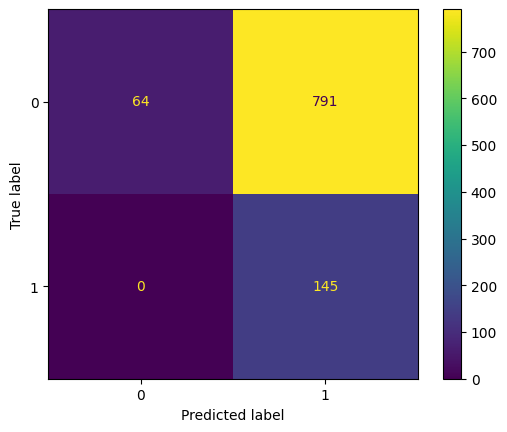

In [131]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

fig = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig.plot()

### Interpretabilidade

In [132]:
# Importância das variáveis

# Obter a importância das variáveis
importancias = best_model.feature_importances_
nomes_features = preprocessor.get_feature_names_out()

# Criar um Dataframe com as importâncias e nomes das features
df_importancias = pd.DataFrame({ 'feature': nomes_features, 'importancia': importancias })

# Ordenar o Dataframe por importância (decrescente)
df_importancias = df_importancias.sort_values('importancia', ascending=False).reset_index(drop=True)

In [133]:
# Criar um gráfico com as importâncias
fig = px.bar(
    df_importancias.head(10),
    x='importancia',
    y='feature',
    orientation='h',
    title='Importância das 10 primeiras features',
    labels={'importancia': 'Importância', 'feature': 'Feature' },
    color='importancia',
    color_continuous_scale='Viridis'
)

# Personalizar o layout
fig.update_layout(
    height=600,
    yaxis={'categoryorder': 'total ascending'},
)

fig.show()

In [134]:
# Visualizar as árvores da Random Forest

# Função para visualizar árvore
def visualizar_arvore(modelo, indice_arvore, max_profundidade=5):
    plt.figure(figsize=(20, 10))
    plot_tree(
        modelo.estimators_[indice_arvore],
        feature_names=nomes_features,
        class_names=['0', '1'],
        max_depth=max_profundidade,
        fontsize=9,
        proportion=True,
        precision=2,
    )
    plt.title(f'Árvore {indice_arvore} da Random Forest', fontsize=14)
    plt.tight_layout()
    plt.show()


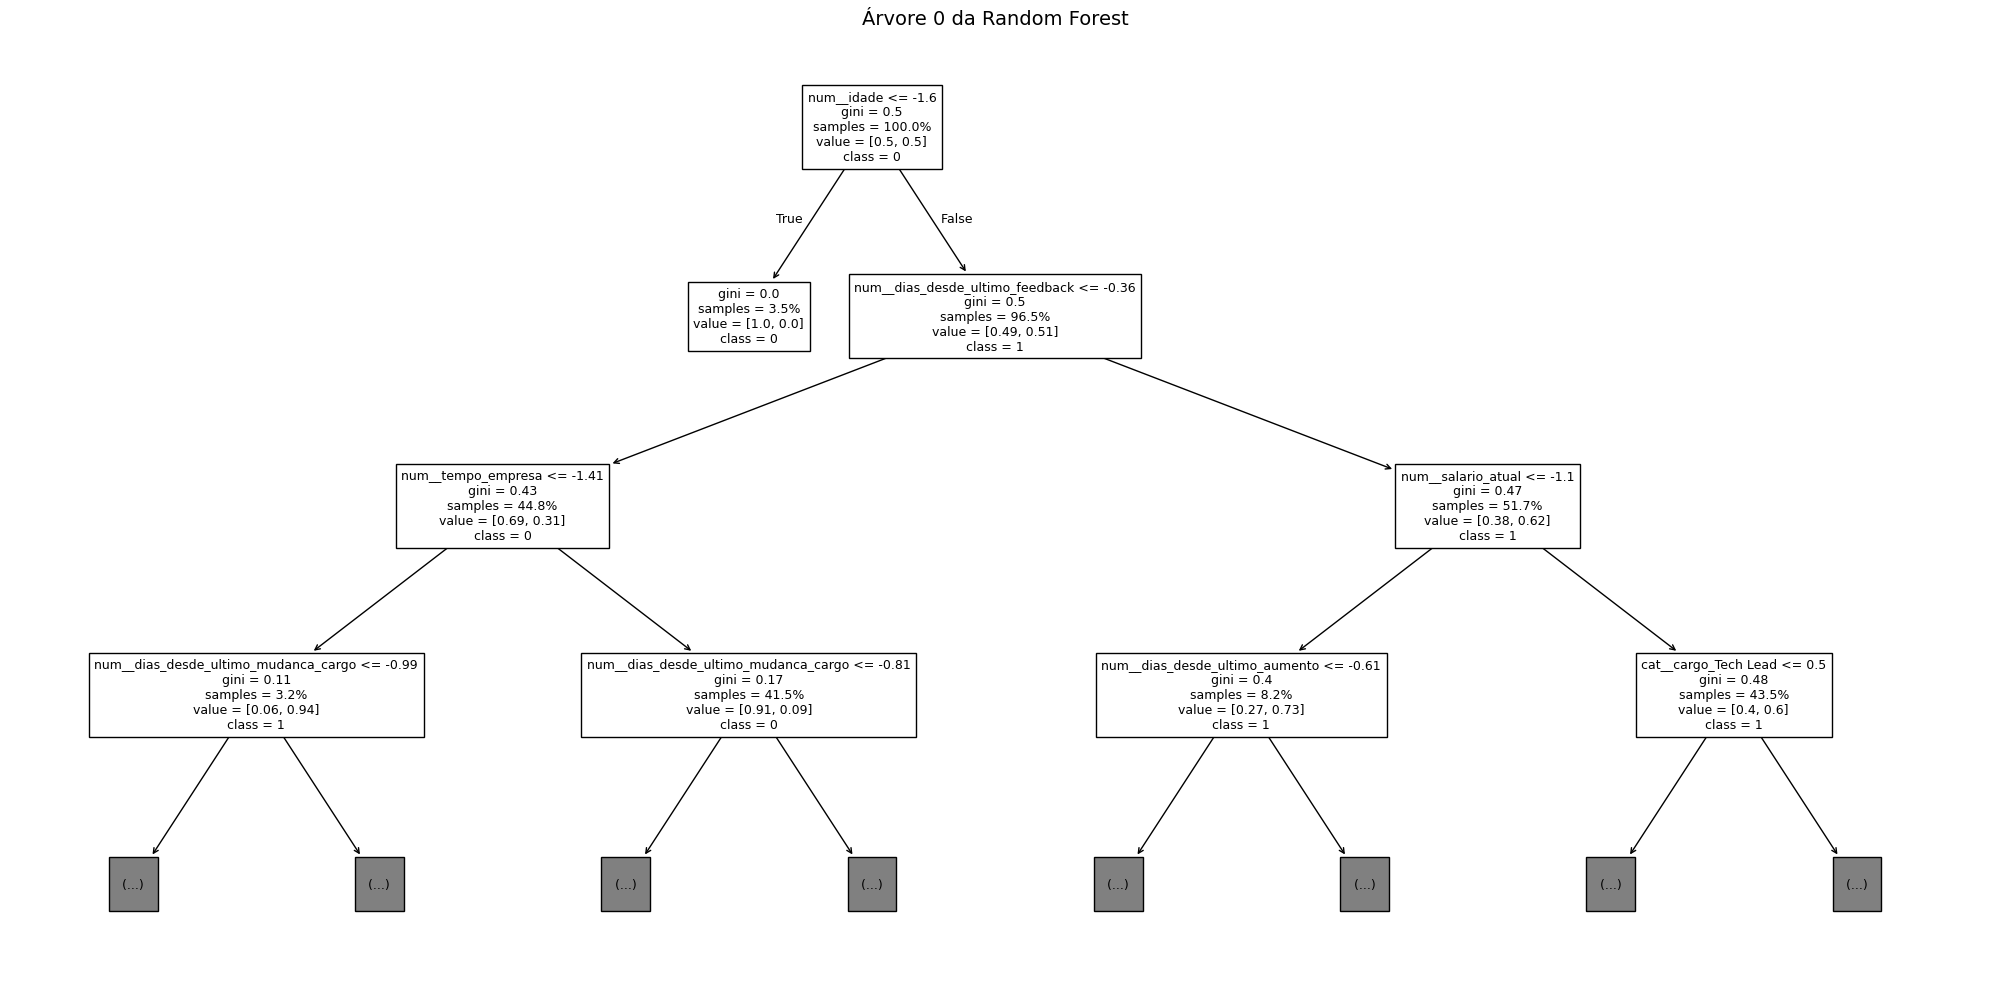

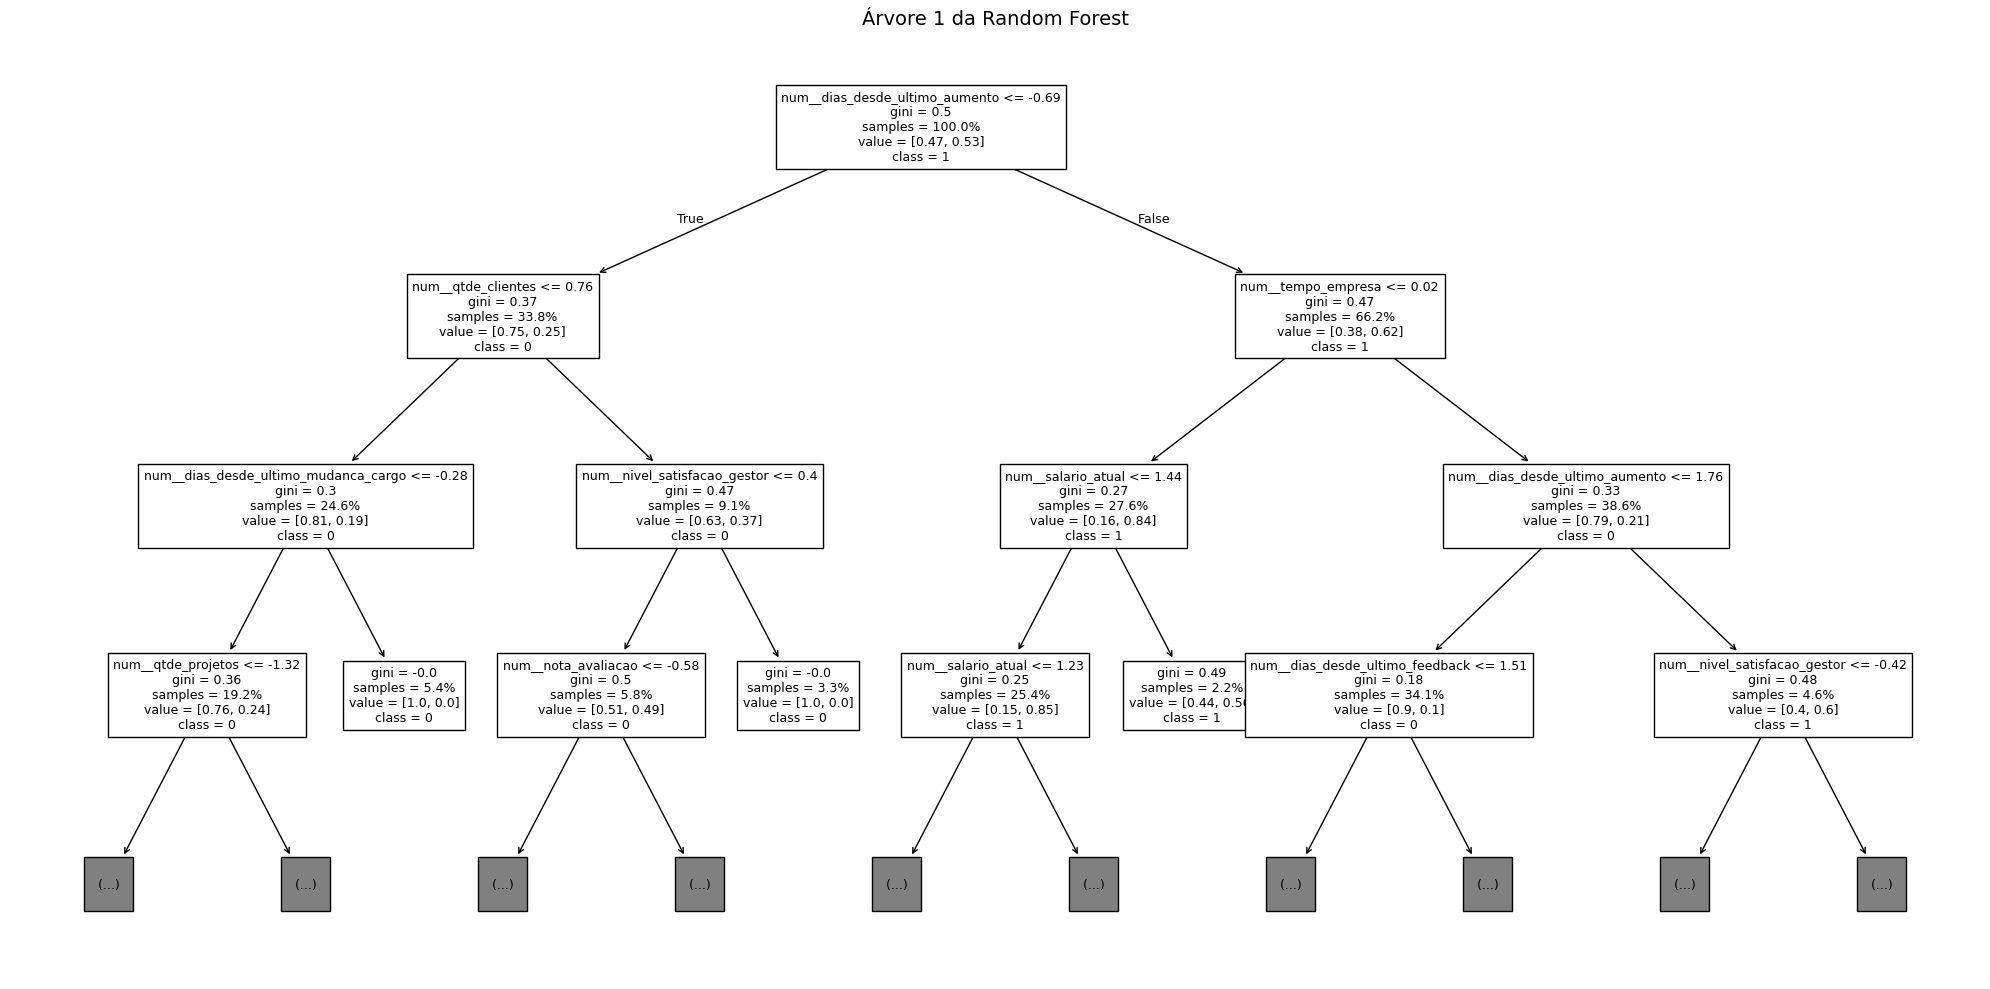

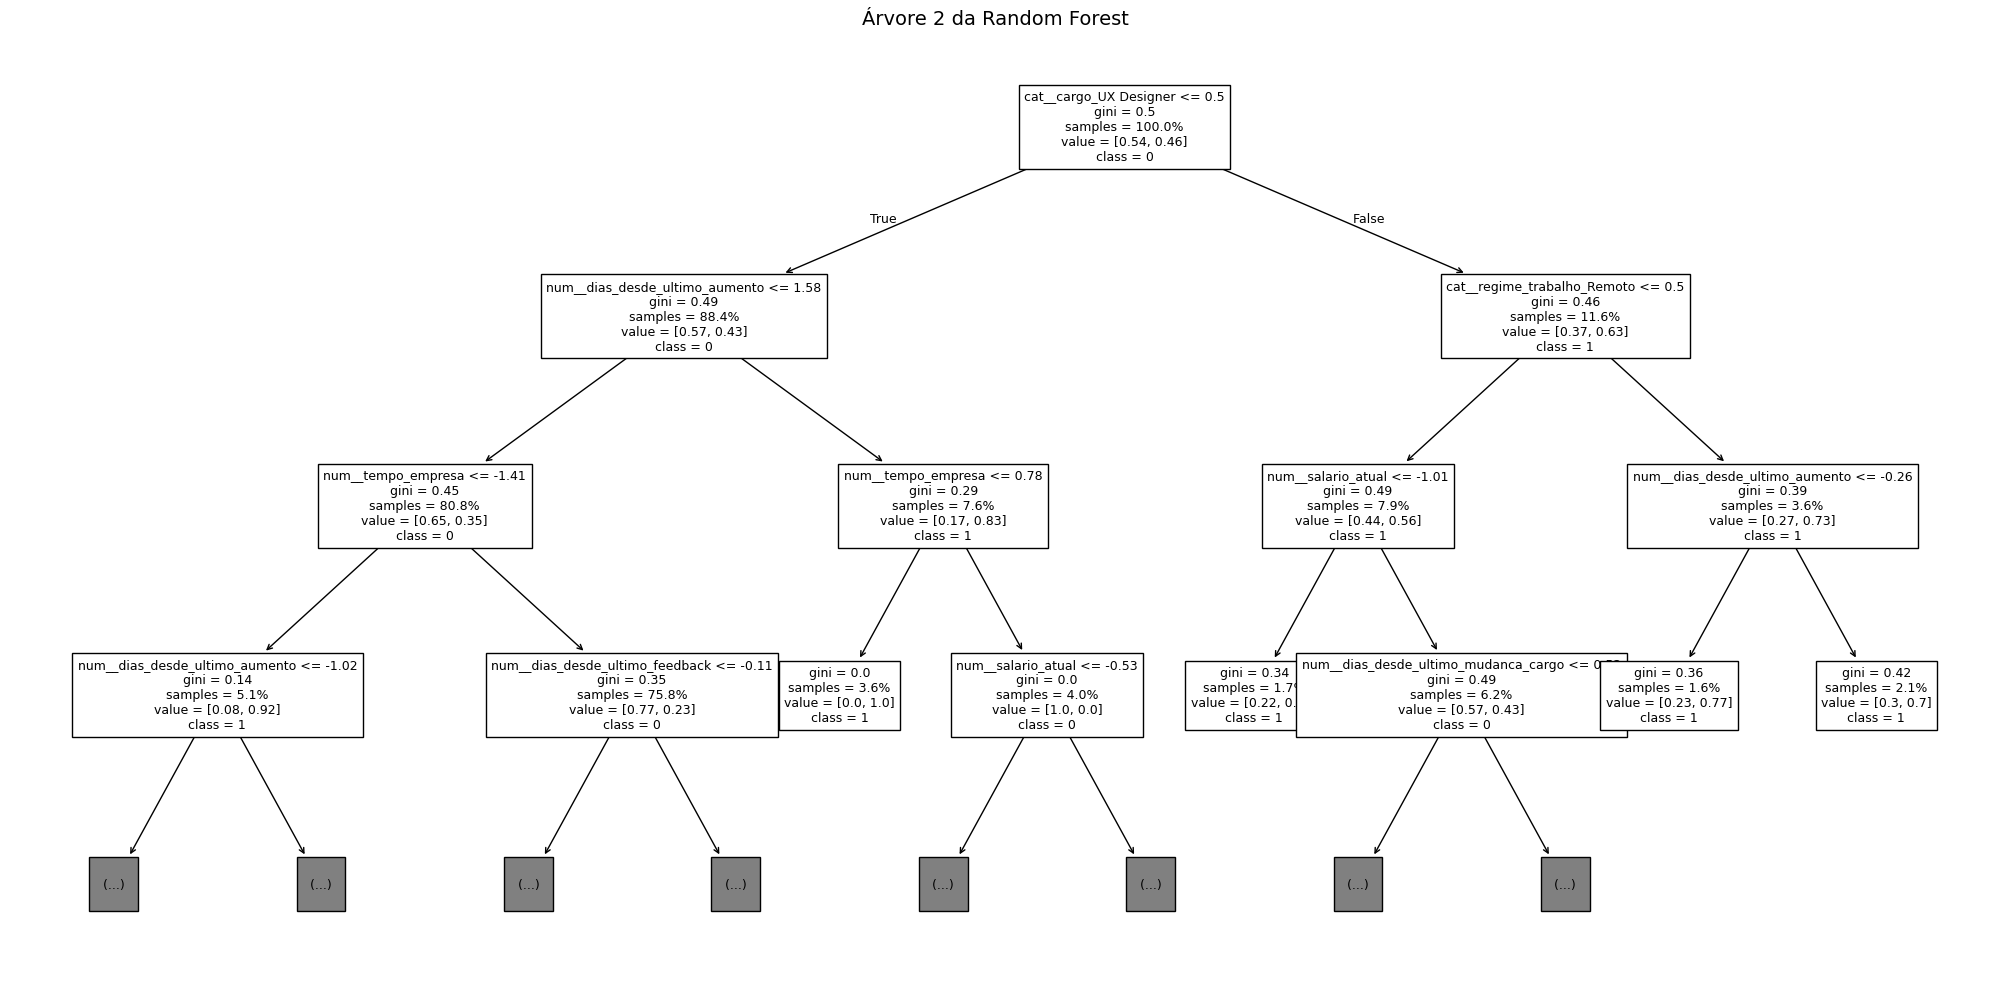

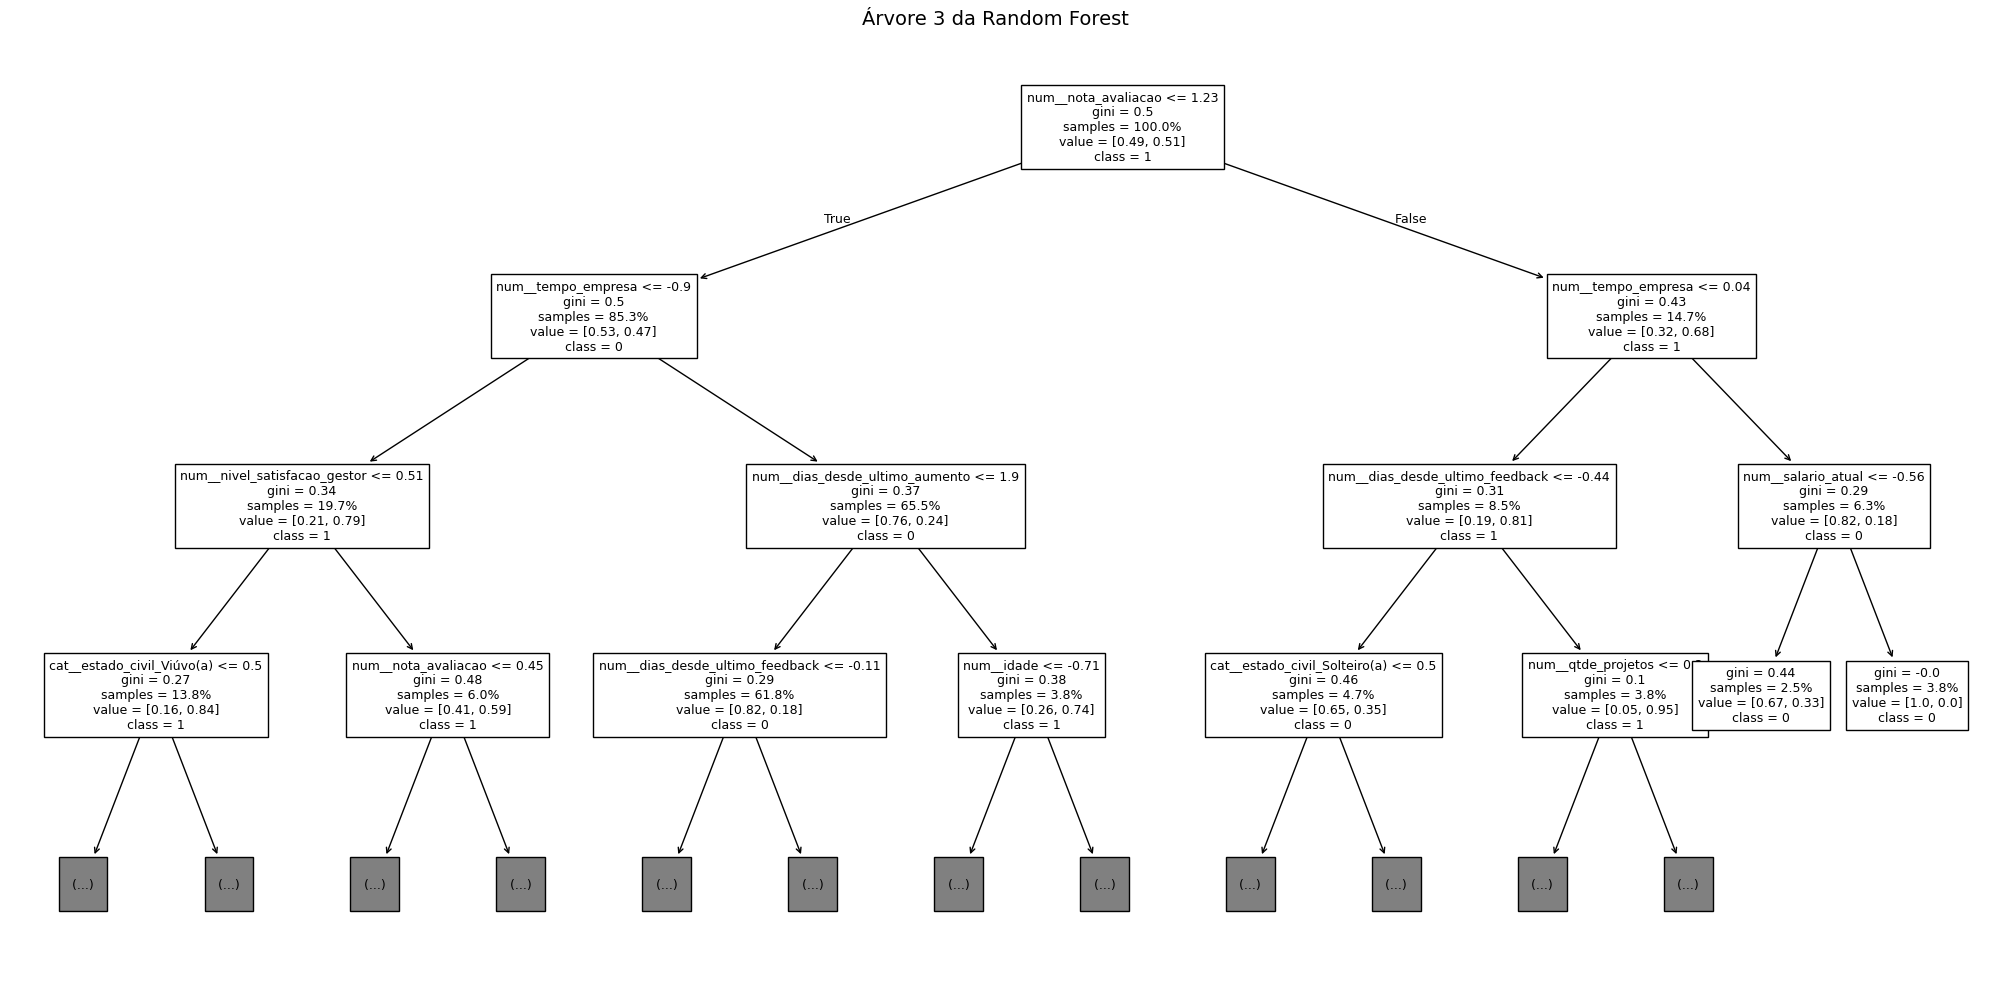

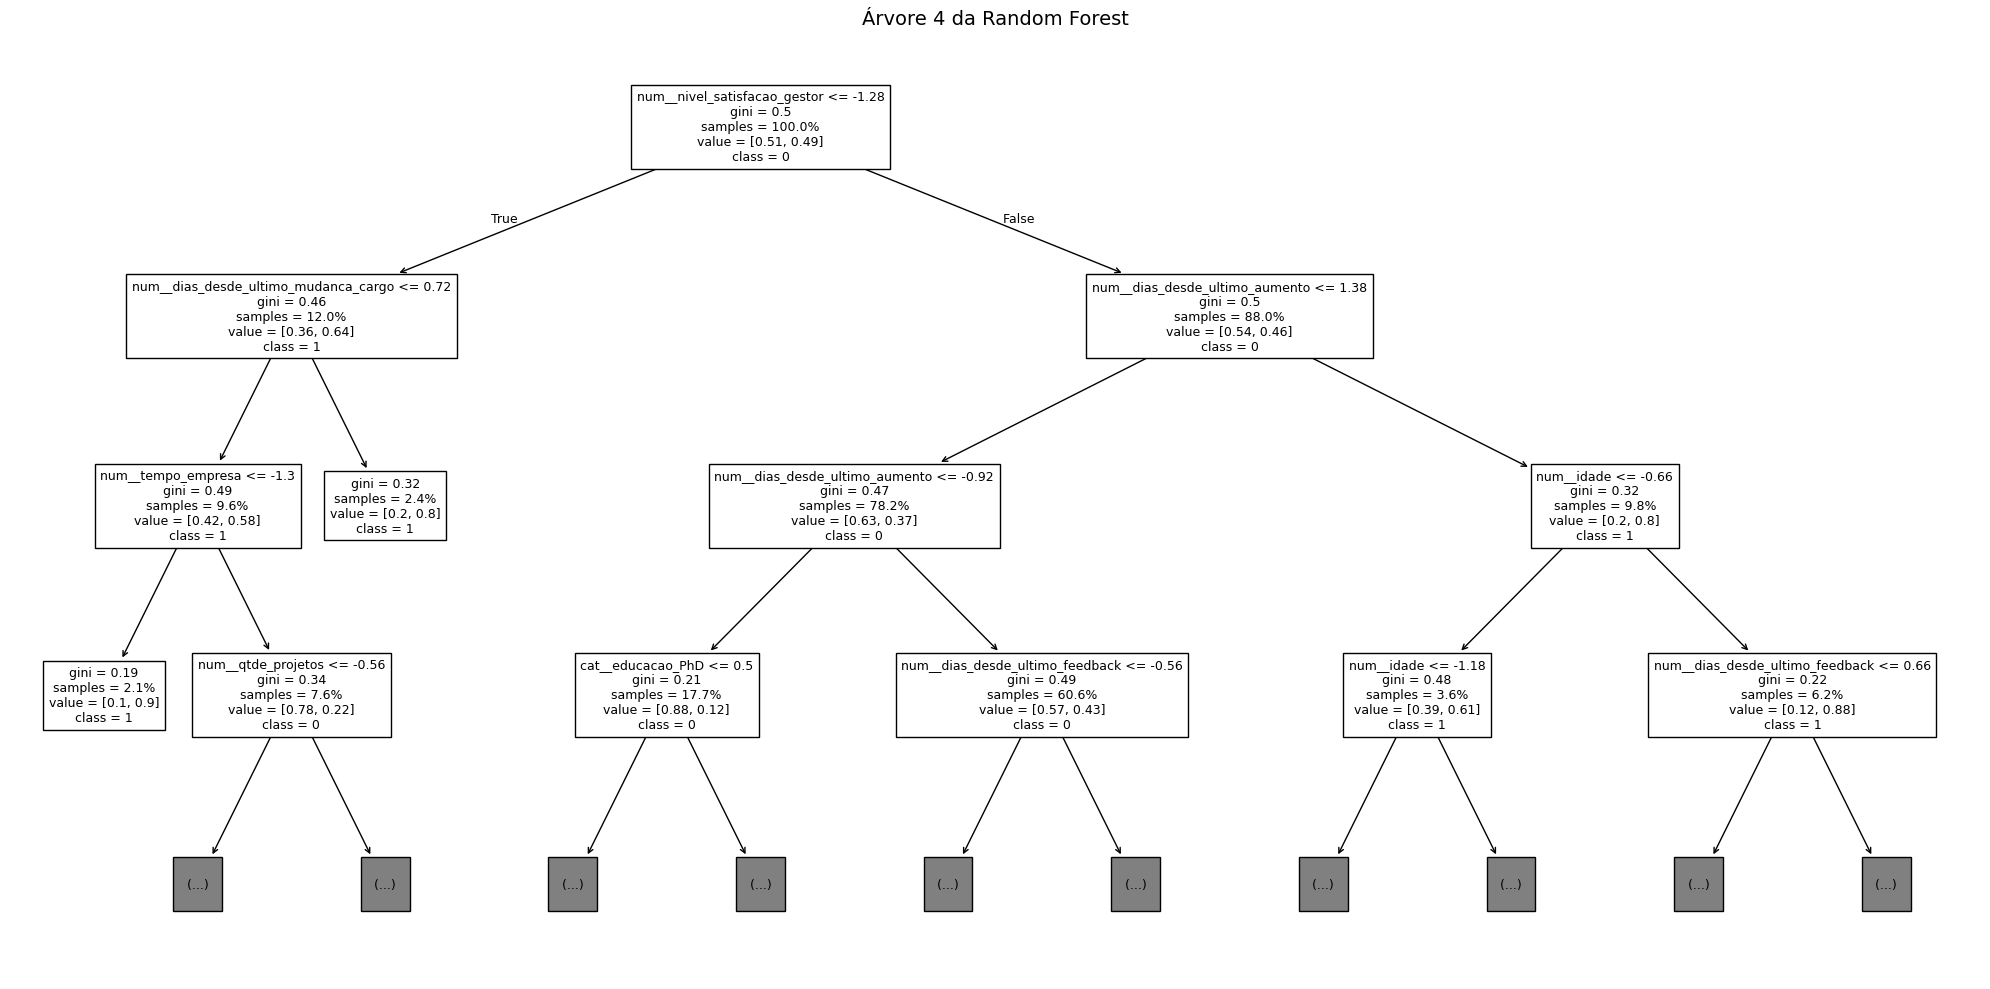

In [135]:
# Visualizar as 5 primeiras árvores
for i in range(5):
    visualizar_arvore(best_model, i, 3)

### Apresentar Plots Shapley Values

In [136]:
# Rodar o explainer no conjunto de treinamento
explainer_class = shap.Explainer(best_model.predict, X_train, feature_names=nomes_features)

In [137]:
# Calcular Shapley Values no conjunto de testes
shap_values_class = explainer_class(X_test)

PermutationExplainer explainer:   3%|▎         | 27/1000 [00:29<15:53,  1.02it/s]

PermutationExplainer explainer: 1001it [12:06,  1.36it/s]                          


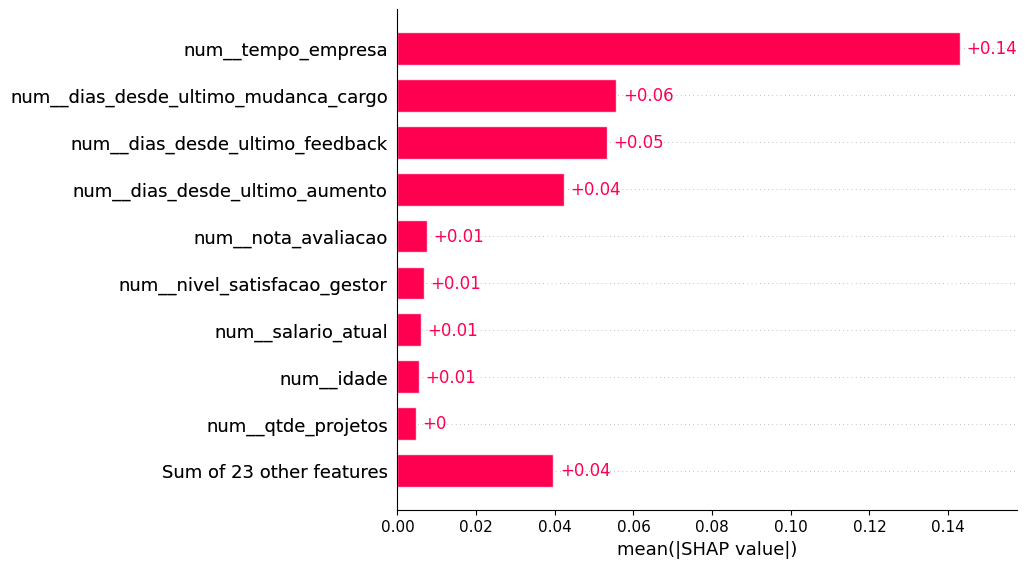

In [138]:
# Plotar a contribuição
shap.plots.bar(shap_values_class)

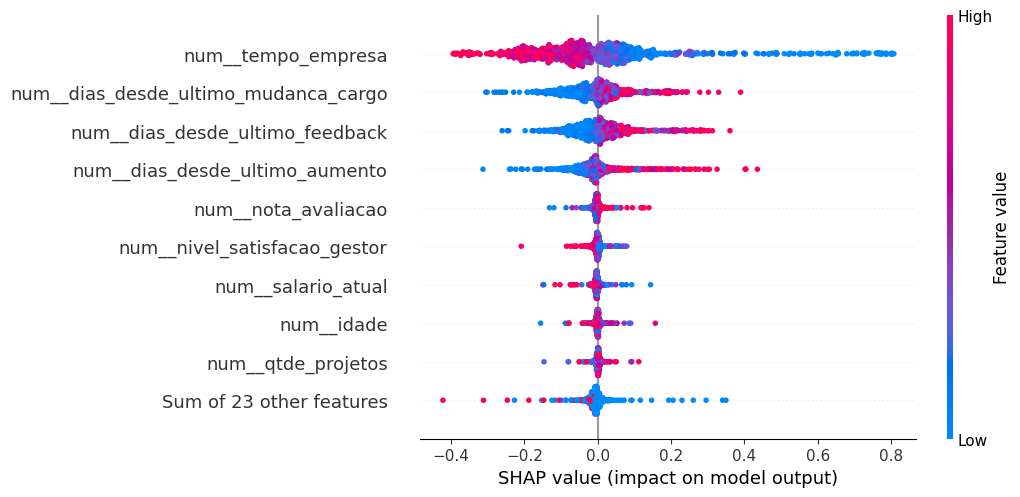

In [139]:
# Plot de Beeswarm Global
shap.plots.beeswarm(shap_values_class, max_display=10)

In [140]:
# Criar um Dataframe contendo y_test e y_pred
df_comparacao = pd.DataFrame({ 'y_test': y_test, 'y_pred': y_pred })

# Mostrar Dataframe
df_comparacao

,y_test,y_pred
1617,0,0
885,0,0
433,0,1
188,0,1
1264,0,1
...,...,...
784,0,1
1914,0,1
227,1,1
316,1,1


In [141]:
def inverse_transform_manual(X_transformed, preprocessor, feature_names):

    # Armazenar nomes originais das features
    feature_names_original = feature_names

    # Criar um Dataframe com os dados tranformados
    df_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

    # Criar um Dataframe vazio para receber os dados originais
    df_original = pd.DataFrame(columns=feature_names_original)

    # Loop em cada transformador
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            # Para features númericas, usar o inverse_transform
            df_original[features] = transformer.inverse_transform(
                df_transformed[[f'{name}__{f}' for f in features]]
            )
        elif name == 'cat':
            # Para features categóricas, precisamos identificar as colunas e qual delas tem valor 1
            for feature in features:
                cols = [col for col in df_transformed.columns if col.startswith(f'{name}__{feature}')]
                for col in cols:
                    if df_transformed[col].iloc[0] == 1:
                        df_original[feature] = col.split('__')[-1]
                        break
    return df_original

In [142]:
# Trazer dados originais do index 227
inverse_transform_manual(X_test[[227]], preprocessor, X.columns)

,idade,genero,estado_civil,educacao,regime_trabalho,cargo,salario_atual,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultimo_mudanca_cargo
0,33.0,genero_Outro,estado_civil_Viúvo(a),educacao_PhD,regime_trabalho_Presencial,cargo_Product Manager,24347.0,7.9,NaN,7.0,4.0,4.1,1052.0,948.0,299.0,203.0


In [143]:
# Probabilidade do index 227
y_pred_proba[227]

array([0.86834693, 0.13165307])

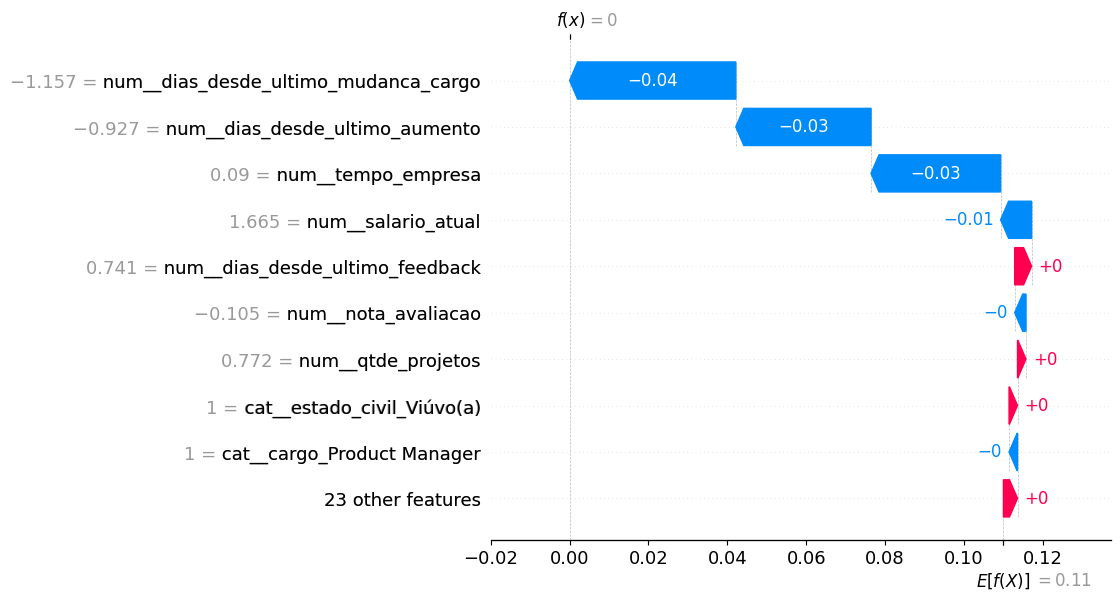

In [144]:
# Plotar os Shap Values para um exemplo específico
shap.plots.waterfall(shap_values_class[227], max_display=10)